# Figure 5: Probability distribution over time conditioned on non-extinction for the 3 mosquito model

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [11]:
import numpy as np
import itertools
from scipy.linalg import expm
import pylab as plt
import matplotlib
import sympy as sp

Importing required scripts

In [12]:
import importlib
import Rate_transitions
import Finding_P_dist
import Finding_full_Q
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
Pget = Finding_P_dist.Pget
getQ = Finding_full_Q.getQ_Hughes
F = Hughes_model.F_hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Finding the coexistence steady state

In [8]:
# defining parameters as symbols so can solve symbolically
b,nm,nw,u,v,phi,d,dw,k,h = sp.symbols('b nm nw u v phi d dw k h')

zm = ((nm + (1-u)*nw)/(nm + nw))*(nm + (1-v)*phi*nw)
zw = v*phi*nw

eq1 = b*zm*(sp.exp(-h*(nm+nw)**k)) - d*nm      # ODE for wild-types
eq2 = b*phi*v*(sp.exp(-h*(nm+nw)**k)) - dw     # ODE for Wolbachia-infected, we have taken out a factor nw

sol_coexist = sp.solve([eq1,eq2],[nm,nw])   # solving symbolically

Parameter values

In [24]:
# set some parameter values 

K = 3            # reproductive carrying capacity
k = 0.3          # Mosquito competition parameter
h = 0.19*100**k  # Mosquito competition parameter
d1 = 12/100      # wild-type death rate
d2 = 12/100      # Wolbachia death rate
xstar = 2        # imposed steady state (for wild type population)
b1 = round(d1/F(xstar,h,k,K),2) # wild-type per capita birth rate
phi = 7/10       # Wolbachia fitness
b2 = b1*phi      # Wolbachia  per capita fitness
v = 10/10        # probability of vertical transmission
u = 10/10        # probability of viable offspring


# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'u': u,
              'v': v,
              'phi': phi,
              'h': h,
              'k': k}

In [25]:
# the second solution corresponds to the coexistence steady state
# substitute in parameter values to find explicit solution
nm_co = sol_coexist[1][0].subs({'b':b1,'u':1,'v':v,'phi':phi,'d':d1,'dw':d2,'k':k,'h':h}).evalf()
nw_co = sol_coexist[1][1].subs({'b':b1,'u':1,'v':v,'phi':phi,'d':d1,'dw':d2,'k':k,'h':h}).evalf()
print('coexistence steady state is',(nm_co,nw_co))
# so we have to approximate the coexistence SS with (1,1)

coexistence steady state is (0.256381035929544, 0.109877586826947)


Construct a dictionary of all the state variables

In [26]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 3   # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
print(state_dict)

{0: array([0, 0]), 1: array([0, 1]), 2: array([0, 2]), 3: array([0, 3]), 4: array([1, 0]), 5: array([1, 1]), 6: array([1, 2]), 7: array([2, 0]), 8: array([2, 1]), 9: array([3, 0])}


Construct the full transition matrix

In [27]:
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)    # total number of states

Q = getQ(state_dict,params_dict)
print(Q)

[[-0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.12       -0.21856379  0.09856379  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.24       -0.40550686  0.16550686  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.36       -0.36        0.          0.
   0.          0.          0.          0.        ]
 [ 0.12        0.          0.          0.         -0.26080541  0.
   0.          0.14080541  0.          0.        ]
 [ 0.          0.12        0.          0.          0.12       -0.38186302
   0.08275343  0.          0.05910959  0.        ]
 [ 0.          0.          0.12        0.          0.          0.24
  -0.36        0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.24        0.
   0.         -0.47643836  0.          0.23643836]
 [ 0.          0.          0.          0.          0. 

Plotting the figure

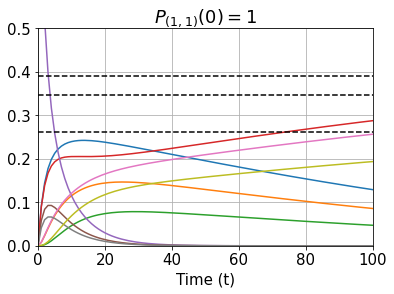

In [35]:
matplotlib.rcParams.update({'font.size': 15})   # font size

t_start = 0            # starting time point
t_range = 750          # ending time point
steps = t_range        # number of time points
initial_state = np.array((1,1))      # starting at the coexistence SS (approximately)

# returns the probability distribution of the household being in each state for each time point and the time points
P_vec,ts = Pget(t_start,t_range,Q,steps,initial_state,state_dict)

# plotting the probabilities of being in each labelled state *conditioning on non-extinction*
plt.plot(ts,P_vec[:,1]/(1-P_vec[:,0]), label='(0,1)') 
plt.plot(ts,P_vec[:,2]/(1-P_vec[:,0]), label='(0,2)')
plt.plot(ts,P_vec[:,3]/(1-P_vec[:,0]), label='(0,3)')
plt.plot(ts,P_vec[:,4]/(1-P_vec[:,0]), label='(1,0)')
plt.plot(ts,P_vec[:,5]/(1-P_vec[:,0]), label='(1,1)')
plt.plot(ts,P_vec[:,6]/(1-P_vec[:,0]), label='(1,2)')
plt.plot(ts,P_vec[:,7]/(1-P_vec[:,0]), label='(2,0)')
plt.plot(ts,P_vec[:,8]/(1-P_vec[:,0]), label='(2,1)')
plt.plot(ts,P_vec[:,9]/(1-P_vec[:,0]), label='(3,0)')

plt.xlabel('Time (t)')            # x label
#plt.ylabel('$P_{(i,j)}(t)$')      # y label
plt.title('$P_{(1,1)}(0)=1$')     # title
plt.ylim(0,0.5)                   # y range
plt.xlim(0,100)                   # x range, alter this to achieve each subfigure
plt.grid()                        # adds grid
#plt.legend(loc='right')           # adds legend

# plotting the steady state solutions
### see 'Figure_6' file
plt.axhline(0.3898769, color='black', linestyle='--')
plt.axhline(0.34767302, color='black', linestyle='--')
plt.axhline(0.26245008, color='black', linestyle='--')

plt.savefig('P_dist_cond_phi07_zoom.pdf' , bbox_inches='tight')  # save figure